<a href="https://colab.research.google.com/github/VegemiteEnjoyer/Lecture_data_driven_science/blob/main/Lesson2_Answer_Classification_Sparsemodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
clear()

In [ ]:
# matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
## Generate artificial data for binary classification
## 2値分類のための，人工データの生成
N = 1000 # # of samples
n_features =   4 # # of feautures
labelA = np.ones((N,1)) # labelA
labelB = - np.ones((N,1)) #labelB
label  = np.r_[labelA,labelB]

mean_A   = [0, 0, 0, 0]
mean_B   = [1, 4, 7, 0]
Cov_A    = np.array([[3, -3, -1, 0], [-3, 4, 1, 1], [-1, 1, 8, 1], [0, 1, 1, 6]])
Cov_B    = np.array([[3, -3, -1, 0], [-3, 4, 1, 1], [-1, 1, 8, 1], [0, 1, 1, 6]])

noise_cov = 2        # noise
noise_A = np.random.normal(0, noise_cov, [N, 4])
noise_B = np.random.normal(0, noise_cov, [N, 4])

DATA_labelA = np.random.multivariate_normal(mean_A, Cov_A, N) +noise_A
DATA_labelB = np.random.multivariate_normal(mean_B, Cov_B, N) +noise_B

DATA = np.r_[DATA_labelA, DATA_labelB]

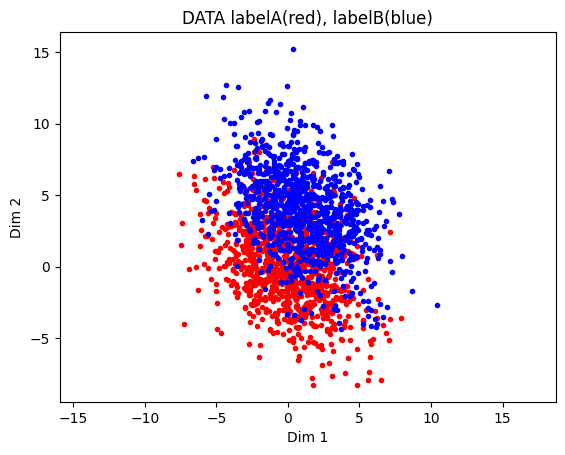

In [ ]:
## Plotting artificial data1
## 人工データのプロット1
plt.plot(DATA_labelA[:, 0], DATA_labelA[:, 1], 'r.')
plt.plot(DATA_labelB[:, 0], DATA_labelB[:, 1], 'b.')
plt.axis('equal')
plt.title('DATA labelA(red), labelB(blue)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid
plt.show()

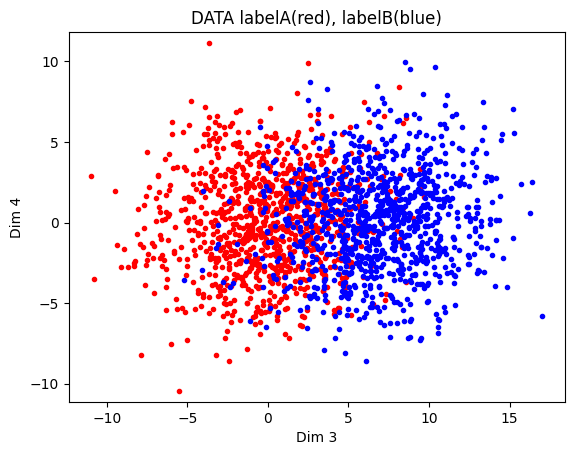

In [ ]:
## Q1 Try plotting Dim3 and Dim4 as well.
## Q2 Try varying the parameters for artificial data generation to change the difficulty of identification.
## 問1 Dim3, Dim4についても、プロットしてみてください。
## 問2 人工データ生成のパラメータを変化させて、識別の難易度を変化させてみてください。

## Plot artificial data2
## 人工データのプロット2
plt.plot(DATA_labelA[:, 2], DATA_labelA[:, 3], 'r.')
plt.plot(DATA_labelB[:, 2], DATA_labelB[:, 3], 'b.')
plt.axis('equal')
plt.title('DATA labelA(red), labelB(blue)')
plt.xlabel('Dim 3')
plt.ylabel('Dim 4')
plt.grid
plt.show()

In [ ]:
#Importing libraries for machine learning
#機械学習用のライブラリのインポート
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

In [ ]:
## Preparing for Exhaustive search (Exact sparse modeling)
def _generate_indicator(n_features):
    """
    Parameters
    ----------
    n_features : int
    Number of features
        特徴量の数

    Returns
    -------
    indicators : ndarray, shape = [n_comb, n_features (+ 1)]
        Indicator vector
    """
    n_comb = 2 ** n_features
    indicators = [
        _transform_indicator(i, n_features) for i in range(n_comb)
    ]
    indicators = np.array(indicators, dtype=int)
    return indicators

def _remove_null_indicator(indicators):
    """
    When fit_intercept is false, no features are used
    Excluding predictive models
    fit_interceptがfalseの時に，特徴量を何も用いない
    予測モデルを除く

    Parameters
    ----------
    indicators : ndarray, shape = [n_indicator, n_features]

    Returns
    -------
    filtered_indicators : ndarray, shape = [n_indicator-1, n_features]
    """
    index = np.arange(indicators.shape[0])
    filtered = index[(indicators == 1).sum(axis=1) > 0]
    return indicators[filtered, :]

def _transform_indicator(i, max_length=None):
    """
    convert integer to binary and generate indicator vector
    整数を二進数にし，Indicator vectorを生成

    Parameters
    ----------
    i : int
        Integer to be converted to Indicator vector
        Indicator vectorに変換する整数

    max_length : int
        ndicator vector length, corresponding to the number of features
        Indicator vectorの長さ, 特徴量の数に対応
        Condition : len(bin(i)[2:]) <= max_length

    Returns
    -------
    indictor : list, shape = [len(bin(i)[2:]) or length]

    ex) Note that the reverse
    reverseされる点に注意
    transform_indicator(6, None)
        6 ---> [0, 1, 1]
    transform_indicator(6, 5)
        6 ---> [0, 1, 1, 0, 0]
    """
    b = bin(i)[2:]
    indicator = list(map(int, list(b)))
    if max_length is not None:
        indicator = [0] * (max_length - len(indicator)) + indicator
    return indicator[::-1]

def _remove_null_indicator(indicators):
    """
    When fit_intercept is false, no features are used
    Excluding predictive models
    fit_interceptがfalseの時に，特徴量を何も用いない
    予測モデルを除く

    Parameters
    ----------
    indicators : ndarray, shape = [n_indicator, n_features]

    Returns
    -------
    filtered_indicators : ndarray, shape = [n_indicator-1, n_features]
    """
    index = np.arange(indicators.shape[0])
    filtered = index[(indicators == 1).sum(axis=1) > 0]
    return indicators[filtered, :]

In [ ]:
## main part
# Data shaping:
#　データの整形-------------------------------------------------------
sc=preprocessing.StandardScaler()
sc.fit(DATA)
DATA_norm=sc.transform(DATA)

# Derive all indicator combinations
# すべてのindicatorの組み合わせを導出
indicators_ = _generate_indicator(n_features)
indicators_ = _remove_null_indicator(indicators_) #Excluding predictive models that use no features
                                                  #特徴量を何も用いない予測モデルを除く

# Evaluate performance with K-partition cross validation
# K分割交差検証（cross validation）で性能を評価する---------------------
skf = StratifiedKFold(n_splits=10, shuffle =True, random_state = 0)
clf =  LinearSVC(loss='squared_hinge', C = 1) #clf: classifier
#lossstr, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’) Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss.
#C Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.


In [ ]:
# Q3 By printing indicators_, make sure that all variable combinations are shown.
# Also, by changing n_features, see how the variable combinations change.
# 問3 indicators_をプリントすることで、すべての変数の組み合わせが表示されていることを確認してください。
# また、n_featuresを変化させることで、変数の組み合わせがどう変化するか、確認してください。
print(indicators_)

[[1 0 0 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 1 0]
 [0 0 0 1]
 [1 0 0 1]
 [0 1 0 1]
 [1 1 0 1]
 [0 0 1 1]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 1]]


In [ ]:
scores = {"mean": [], "std": []}

# Q4 I am using a linear support vector machine this time,
# How can I analyze this problem with a logistic regression model?
# 問4 今回、線形のサポートベクターマシンを用いていますが、
# この問題を、ロジスティック回帰モデルで解析するにはどうすればよいでしょうか？

for i, ind in enumerate(indicators_):
    ## evaluate each model by Cross validation
    this_scores =[]

    for C=1~1000までの100分割の探索
    　　　　　　for train_index, test_index in skf.split(DATA_norm, label):
      　　　#Test and Training data
        X_train = DATA_norm[train_index, :]
        X_train = X_train  [:,ind==1]
        X_test  = DATA_norm[test_index, :]
        X_test  = X_test   [:,ind==1]
        y_train, y_test = label[train_index], label[test_index]

      if X_train.ndim == 1:
        X_train = X_train[:, np.newaxis]
        X_test  = X_test[:, np.newaxis]

      # fit by Linear SVC
      clf.fit(X_train, y_train.flatten())
      # predict
      pred = clf.predict(X_test)
      score = metrics.accuracy_score(y_test.flatten(), pred)
      this_scores.append(score)

# Q5 Please look up the definition of how score is calculated.
# 問5 scoreの計算方法の定義を調べてみてください。
    scores["mean"].append(np.mean(this_scores))  # convert to positive
    scores["std"].append(np.std(this_scores))
    print(indicators_[i,:])
    #print('テストデータに対する正解率： %.4f' % scores["mean"][i])
    print('Percentage correct for test data: %.4f' % scores["mean"][i])


[1 0 0 0]
Percentage correct for test data: 0.5665
[0 1 0 0]
Percentage correct for test data: 0.7620
[1 1 0 0]
Percentage correct for test data: 0.8085
[0 0 1 0]
Percentage correct for test data: 0.8375
[1 0 1 0]
Percentage correct for test data: 0.8450
[0 1 1 0]
Percentage correct for test data: 0.8725
[1 1 1 0]
Percentage correct for test data: 0.8960
[0 0 0 1]
Percentage correct for test data: 0.5165
[1 0 0 1]
Percentage correct for test data: 0.5675
[0 1 0 1]
Percentage correct for test data: 0.7575
[1 1 0 1]
Percentage correct for test data: 0.8050
[0 0 1 1]
Percentage correct for test data: 0.8345
[1 0 1 1]
Percentage correct for test data: 0.8480
[0 1 1 1]
Percentage correct for test data: 0.8760
[1 1 1 1]
Percentage correct for test data: 0.8945
